In [1]:
from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout, Bidirectional
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.layers.merge import Concatenate
import matplotlib.gridspec as gridspec

import random
import scikitplot as skplot
import matplotlib.pyplot as plt
import datetime
from datetime import date
from pandas_datareader import data as pdr

Using TensorFlow backend.
C:\Users\dnishimoto.BOISE\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\dnishimoto.BOISE\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\dnishimoto.BOISE\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as

In [2]:
def generate_csv(symbol,filename):
    current_date=datetime.datetime.now()
    start_date=datetime.datetime(current_date.year-2,1,1)
    df = pdr.get_data_yahoo(symbol,start_date,current_date).reset_index()
    df.to_csv(filename)

In [3]:
#https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/
generate_csv('NFLX','nflx.csv')
url = "nflx.csv"
#url="dpz.csv"

df = pd.read_csv(url,parse_dates=['Date'],index_col='Date')

df.columns = [x.lower() for x in df.columns]
#print(df.head())
df=df.sort_values(by="Date")
#df=df.reset_index()

df=df.drop(["high","low","adj close"],axis=1)
print(df.columns)

df['open_pct_change']=df['open'].pct_change()

print(df["open_pct_change"])

df["open_pct_positive_count"]=0

#######caculate the occurrences of positive open
for index in range(len(df)):
    #print(df.iloc[index])
    count=0
    for index2 in (range(index,0,-1)):
        #print(df.iloc[index2]["open_pct_change"])
        if df.iloc[index2]["open_pct_change"]>0:
            count=count+1
            #print("found",count)
        else:
            break
    #print("count",count)
    df.iloc[index, df.columns.get_loc('open_pct_positive_count')]=count
    #print("new",df.iloc[index]["pct_pos_count"])
    
print(df[df["open_pct_positive_count"]>0])    



Index(['unnamed: 0', 'open', 'close', 'volume'], dtype='object')
Date
2019-01-02         NaN
2019-01-03    0.042117
2019-01-04    0.043227
2019-01-07    0.071733
2019-01-08    0.059186
                ...   
2021-06-18    0.012545
2021-06-21    0.010556
2021-06-22   -0.006180
2021-06-23    0.019938
2021-06-24    0.018644
Name: open_pct_change, Length: 625, dtype: float64
            unnamed: 0        open       close    volume  open_pct_change  \
Date                                                                        
2019-01-03           1  270.200012  271.200012  14969600         0.042117   
2019-01-04           2  281.880005  297.570007  19330100         0.043227   
2019-01-07           3  302.100006  315.339996  18620100         0.071733   
2019-01-08           4  319.980011  320.269989  15359200         0.059186   
2019-01-11           7  330.959991  337.589996  19500400         0.052103   
...                ...         ...         ...       ...              ...   
2021-06-15

In [4]:
####### if the occurrences were greater than 2, did the pct change stay positive

#df["target"]=0
#for index in range(len(df)):
#    pct_chg=df.iloc[index]["open_pct_change"]
#    if index!=0:
#        prior_pct_chg_count=df.iloc[index-1]["open_pct_positive_count"]
#        if (prior_pct_chg_count>=2) & (pct_chg>0):
#             df.iloc[index, df.columns.get_loc('target')]=1

df["buy_count"]=0

for index in range(len(df)):
    count=0
    for index2 in (range(index,0,-1)):
        if df.iloc[index2]["open_pct_change"]>0:
            count=count+1
        else:
            break
    df.iloc[index, df.columns.get_loc('buy_count')]=count
    
df['action']=[ 'Sell' if x['buy_count']==0 else 'Buy' if x['buy_count']==2 else 'Hold' if x['buy_count'] > 2 else 'No Action' for key,x in df.iterrows()]
                
df["target"]=0
for index in range(len(df)):
    action=df.iloc[index]["action"]
    if (action=='Buy'):
             df.iloc[index, df.columns.get_loc('target')]=1
    elif (action=='Sell'):
             df.iloc[index, df.columns.get_loc('target')]=2
        
buy_list=df[df["target"]==1]
for index,item in buy_list.iterrows():
    print(index,item["open"],item["open_pct_positive_count"])
    



2019-01-04 00:00:00 281.8800048828125 2
2019-01-14 00:00:00 334.239990234375 2
2019-01-28 00:00:00 334.70001220703125 2
2019-02-05 00:00:00 353.20001220703125 2
2019-02-25 00:00:00 367.010009765625 2
2019-03-07 00:00:00 360.1600036621094 2
2019-03-12 00:00:00 359.3699951171875 2
2019-03-15 00:00:00 361.0199890136719 2
2019-03-22 00:00:00 375.95001220703125 2
2019-04-01 00:00:00 359.0 2
2019-04-17 00:00:00 365.0499877929688 2
2019-04-23 00:00:00 375.45001220703125 2
2019-05-02 00:00:00 378.0 2
2019-05-17 00:00:00 356.3900146484375 2
2019-06-05 00:00:00 354.3800048828125 2
2019-06-18 00:00:00 355.57000732421875 2
2019-06-25 00:00:00 370.75 2
2019-06-28 00:00:00 370.260009765625 2
2019-07-10 00:00:00 382.7699890136719 2
2019-07-26 00:00:00 328.7900085449219 2
2019-08-09 00:00:00 313.739990234375 2
2019-08-30 00:00:00 298.7799987792969 2
2019-09-09 00:00:00 294.80999755859375 2
2019-09-13 00:00:00 290.6099853515625 2
2019-10-04 00:00:00 268.20001220703125 2
2019-10-29 00:00:00 281.86999511

   open_pct_positive_count  Incidence  Size
0                        0          2   300
1                        1          0   155
2                        2          1    78
3                        3          0    40
4                        4          0    26
5                        5          0    15
6                        6          0     8
7                        7          0     2
8                        8          0     1
40
incidence show the average target value for each group


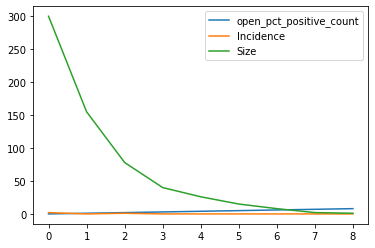

In [5]:
def create_pig_table(basetable, target, variable):
  
    # Create groups for each variable
    groups = basetable[[target,variable]].groupby(variable)
    
    pig_table=groups[target].agg([np.mean, np.size]).reset_index()
    pig_table=pig_table.rename(columns={'mean':'Incidence','size':'Size'})
    #pig_table = groups[target].agg({'Incidence' : np.mean, 'Size' : np.size}).reset_index()

    # Return the predictor insight graph table
    return pig_table

# Calculate the predictor insight graph table for the variable gender
pig_table = create_pig_table(df, "target", "open_pct_positive_count")
print(pig_table)
print(len(df[df['open_pct_positive_count']==3]))

print("incidence show the average target value for each group")

pig_table.plot()
plt.show()

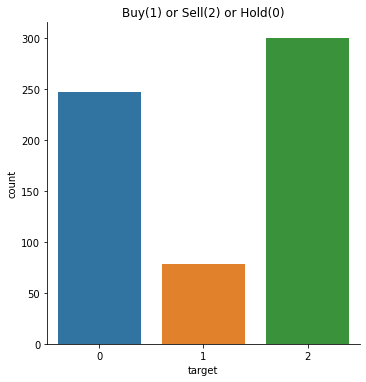

You want to find a stock where Hold counts are high


In [6]:
g=sns.catplot(x="target",data=df,kind="count")  #buy
plt.title('Buy(1) or Sell(2) or Hold(0)')
plt.show()

print('You want to find a stock where Hold counts are high')

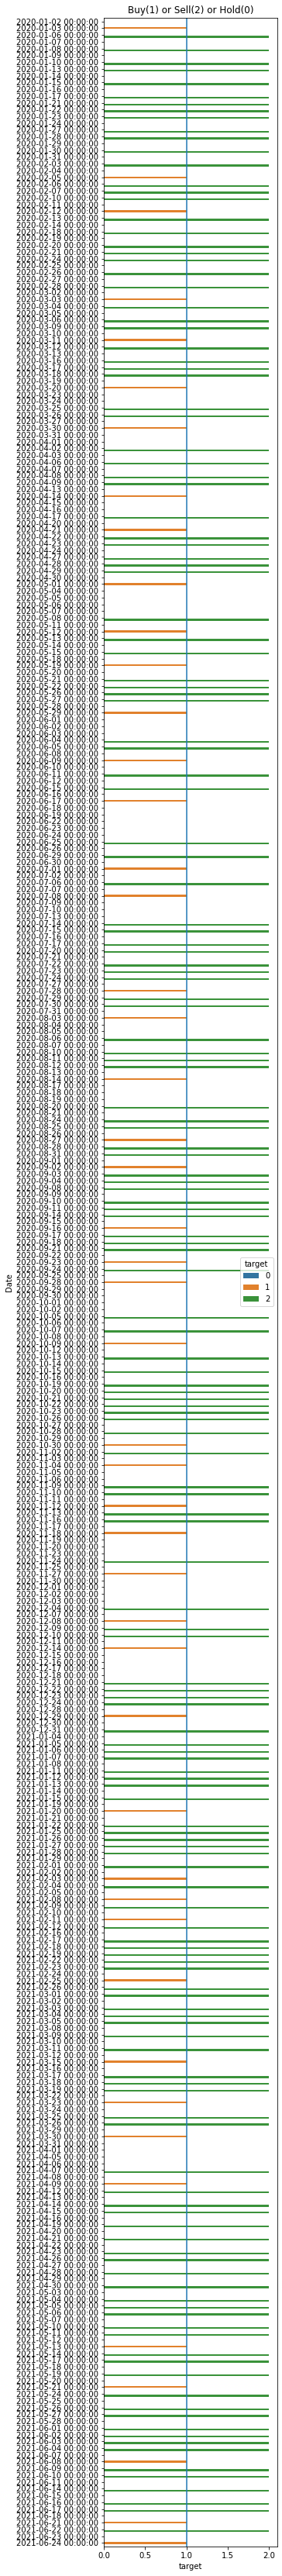

In [7]:

today = datetime.datetime.today()
filter=df.index.year >=  today.year-1
results=df[filter]

plt.figure(figsize=(4,60))
sns.barplot(data=results, x='target', y=results.index, hue='target')
plt.axvline(x=1, ymin=0, ymax=1)
plt.title('Buy(1) or Sell(2) or Hold(0)')
plt.show()

In [66]:
#https://towardsdatascience.com/demand-prediction-with-lstms-using-tensorflow-2-and-keras-in-python-1d1076fc89a0
def create_dataset(dataset, look_back=3):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [117]:
#X_train = np.reshape(train_set, (train_set.shape[0], 1, train_set.shape[1]))
#X_test = np.reshape(test_set, (test_set.shape[0], 1, test_set.shape[1]))

#samples=X_train.shape[0]

#features=len(data.columns)
#print("X_train {} y_train {} ".format(len(X_train),len(y_train)))
#print(len(X_test))
#COLUMNS=['open_pct_change','open']
COLUMNS=['open']
dataset=df[COLUMNS]
#dataset=np.array(dataset).reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(np.array(dataset).reshape(-1,1))
#dataset=np.array(pd.DataFrame({"C1":[1,2,3,4,5,6],"C2":[-1,-2,-3,-4,-5,-6],"Y":[7,8,9,10,11,12]})).reshape(-1,1)

train_size = int(len(dataset) * 0.60)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
#print(len(train), len(test))

look_back=3
trainX=[]
testX=[]
y_train=[]

#print(train)
#print(len(train))
#for i in range(len(train)-look_back-1):
#    a = train[i:(i+look_back)]
#    b = dataset[i + look_back]
#    print(a,b)
#    print("train sequence",a)
#    trainX.append(a)
#trainX=np.array(trainX)
#print(trainX)

#for i in range(len(test)-look_back-1):
#    a = test[i:(i+look_back)]
#    print("test sequence",a)
#    testX.append(a)
#testX=np.array(testX)
#print(testX)

trainX, y_train = create_dataset(train, look_back)
testX, y_test = create_dataset(test, look_back)

#print(y_train)

X_train = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
X_test = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

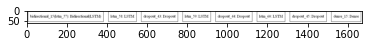

In [118]:
#1. The LSTM input layer must be 3D.
#2. The meaning of the 3 input dimensions are: samples, time steps, and features.
#3. The LSTM input layer is defined by the input_shape argument on the first hidden layer.
#4. The input_shape argument takes a tuple of two values that define the number of time steps and features.
#5. The number of samples is assumed to be 1 or more.

#Samples. One sequence is one sample. A batch is comprised of one or more samples.
#Time Steps. One time step is one point of observation in the sample.
#Features. One feature is one observation at a time step.

#input layer expects a 3D array of data when fitting the model and when making predictions, 
#even if specific dimensions of the array contain a single value, e.g. one sample or one feature.

#The input shape is supposed in the format (no_of_samples,no_of_timesteps,features)

#The input to every LSTM layer must be three-dimensional.
# expected input data shape: (batch_size, timesteps, data_dim)

n_future = 1
features=2
timeSteps=4

model = Sequential()

model.add(Bidirectional(LSTM(units=50, return_sequences=True, 
                             input_shape=(X_train.shape[1], 1))))

model.add(LSTM(units= 50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units= 50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units= 50))
model.add(Dropout(0.2))
model.add(Dense(units = n_future))

model.compile(optimizer="adam", loss="mean_squared_error", metrics=["acc"])



plot_model(model, to_file='model.png')
img=plt.imread('model.png')
plt.imshow(img)
plt.show()



In [119]:
model.fit(X_train, y_train,epochs=50  )

Epoch 1/50
371/371 [==============================] - 2s 6ms/step - loss: 0.0896 - acc: 0.0027
Epoch 2/50
371/371 [==============================] - 0s 315us/step - loss: 0.0618 - acc: 0.0027
Epoch 3/50
371/371 [==============================] - 0s 318us/step - loss: 0.0275 - acc: 0.0027
Epoch 4/50
371/371 [==============================] - 0s 296us/step - loss: 0.0154 - acc: 0.0027
Epoch 5/50
371/371 [==============================] - 0s 326us/step - loss: 0.0124 - acc: 0.0027
Epoch 6/50
371/371 [==============================] - 0s 305us/step - loss: 0.0102 - acc: 0.0027
Epoch 7/50
371/371 [==============================] - 0s 367us/step - loss: 0.0076 - acc: 0.0027ETA: 0s - loss: 0.0092 - acc: 0.0052  
Epoch 8/50
371/371 [==============================] - ETA: 0s - loss: 0.0055 - acc: 0.005 - 0s 310us/step - loss: 0.0050 - acc: 0.0027
Epoch 9/50
371/371 [==============================] - 0s 307us/step - loss: 0.0034 - acc: 0.0027
Epoch 10/50
371/371 [==============================] 

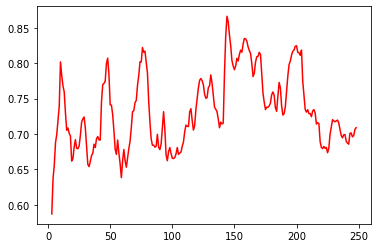

In [120]:
#print(X_test)
prediction = model.predict(X_test)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(prediction)+look_back, :] = prediction
# shift test predictions for plotting
#plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot, color='red')
#plt.plot(testPredictPlot)
#plt.legend(['Actual','Train','Test'])
plt.show()

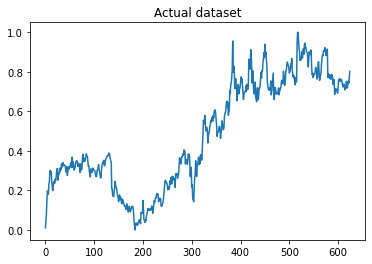

In [121]:
plt.plot(dataset)
plt.title('Actual dataset')
plt.show()